# Ising GNN

## Imports

In [1]:
import sys
import os

# Add the parent directory of src to the system path
sys.path.append(os.path.abspath('../src'))

from sklearn.decomposition import PCA
from sklearn.cluster import k_means
import numpy as np
import matplotlib.pyplot as plt
from numba import jit,prange
import time
from utils import import_data, compute_KNN_graph, create_batch,reconstruct_symmetric_matrix, read_motion, remove_triangle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch_geometric
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.utils import dense_to_sparse
from sklearn.model_selection import cross_validate
from tqdm import tqdm
from torch_geometric.loader import DataLoader
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score

In [ ]:
import torch
import math

print(torch.backends.mps.is_available()) #the MacOS is higher than 12.3+
print(torch.backends.mps.is_built()) #MPS is activated

In [ ]:
import matplotlib.pyplot as plt

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [ ]:
a = ut.reconstruct_symmetric_matrix(333,df[df.Subject == 1019436].iloc[:,1:-37]) #1019436
geo = []
r = []
for i in range(X.shape[0]):
    b = reconstruct_symmetric_matrix(333, X[i,:])  
    geo.append(geodesic_distance_svd(a,b))
    r.append(pearson_diss(a,b))

# Temperature vs Graph Metrics

In [99]:
import sys
import os

# Add the parent directory of src to the system path
sys.path.append(os.path.abspath('../src'))

import pandas as pd
import utils as ut
import numpy as np
from model.model import GCN

import torch
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns


# ADHD 333
df = pd.read_csv('/Users/rodrigo/Documents/data/Thesis/adhd_dataset_gordon.csv')
N = 333

# Health subjects
df = df[df['DX'] != 0]
df = df[df[' Max Rotation (degree)'] < 3]
df = df[df['Max Motion (mm)'] < 3]

X_fmri = df.iloc[:,1:-37]

y = df['Age']

A = ut.reconstruct_symmetric_matrix(N, X_fmri.iloc[:,:].mean(axis=0))
train_data, val_data = ut.create_graph(X_fmri, X_fmri, y, y, size=N, method={'knn_group' : ut.compute_KNN_graph(A, 15)})#, method={'threshold': 0.8})
train_loader, val_loader = ut.create_batch(train_data, val_data, batch_size=32)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load model
model = GCN(N, 3).to(device)
model.load_state_dict(torch.load('/Users/rodrigo/Documents/data/Thesis/model_params_333_TRUE.pth'))

model.eval()

y_pred_aux_age = []
for y_i in val_loader:
    y_pred_aux_age.append((model(y_i))[1].detach().numpy().ravel()[0])


y = pd.DataFrame(y)
y['y_pred'] = y_pred_aux_age
y = y.dropna()
y['Subject'] = df['Subject']


/var/folders/jr/719jfw9158lghhhwj59_c2pm0000gn/T/ipykernel_59047/2953688896.py:19: DtypeWarning: Columns (55286) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/rodrigo/Documents/data/Thesis/adhd_dataset_gordon.csv')
/var/folders/jr/719jfw9158lghhhwj59_c2pm0000gn/T/ipykernel_59047/2953688896.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.a

In [102]:

from graph_metrics import GraphMetrics

# Initialize an empty DataFrame to store all results
all_metrics_df = pd.DataFrame()

for subject in df['Subject'].unique()[:100]:
    print(subject)

    adj_matrix = ut.reconstruct_symmetric_matrix(333, df[df.Subject == subject].iloc[:,1:-37], 1)

    # Initialize the GraphMetrics class with the adjacency matrix
    metrics = GraphMetrics(adj_matrix)

    # Calculate community-based metrics
    metrics_dict = metrics.calculate_global_metrics()

    # Convert the dictionary to a DataFrame
    metrics_df = pd.DataFrame.from_dict(metrics_dict, orient='index', columns=['Value'])

    # Reset the index to make it more readable
    metrics_df = metrics_df.reset_index()

    # Rename the columns
    metrics_df.columns = ['Metric', 'Value']

    # Add additional columns for Group, Time, and Subject

    metrics_df['Subject'] = subject

    # Append the current subject's metrics to the cumulative DataFrame
    all_metrics_df = pd.concat([all_metrics_df, metrics_df], ignore_index=True)

# Display the final DataFrame
print(all_metrics_df)
all_metrics_df['Change'] = all_metrics_df.groupby(['Subject','Metric'])['Value'].diff()
#all_metrics_df = all_metrics_df.dropna().drop(columns='Time')

1019436
1541812
1577042
1623716
1873761
1996183
2014113
2026113
2081148
2299519
3119327
3154996
3160561
3170319
3310328
3519022
3611827
3917422
4275075
4362730
6453038
8337695
10002
10005
10007
10011
10012
10013
10015
10017
10018
10019
10020
10022
10025
10026
10028
10029
10030
10032
10033
10035
10037
10040
10041
10042
10044
10047
10048
10049
10050
10051
10056
1023964
1057962
1099481
1187766
1208795
1283494
1471736
1497055
1511464
1517240
1740607
1780174
1918630
1992284
2030383
2054438
2107638
2230510
2260910
2297413
2306976
2497695
2570769
2682736
2741068
2773205
2821683
2854839
2950672
2983819
2996531
10060
10061
10062
10064
10067
10071
10072
10073
10074
10075
10078
10081
10085
10086
10087
10090
                             Metric      Value  Subject
0                average_clustering   0.087330  1019436
1    average_betweenness_centrality   0.007174  1019436
2               average_path_length   0.002146  1019436
3                    average_degree  32.543612  1019436
4             

In [104]:
for metric in all_metrics_df.Metric.unique():
    print(metric)
    print(stats.pearsonr(all_metrics_df[all_metrics_df.Metric == metric].Value, y['y_pred'].iloc[:100]))


average_clustering
PearsonRResult(statistic=0.7803840287420903, pvalue=1.0638190547818063e-21)
average_betweenness_centrality
PearsonRResult(statistic=-0.07401516140207114, pvalue=0.4642596734027057)
average_path_length
PearsonRResult(statistic=0.6988075846123307, pvalue=6.26390222637015e-16)
average_degree
PearsonRResult(statistic=0.8526422655215908, pvalue=2.2125689104059412e-29)
degree_std
PearsonRResult(statistic=0.7266471368409926, pvalue=1.1548580764204807e-17)


# Max Likelihood  metropolis

In [2]:
# !pip install ipython-autotime
# !pip install numba

import matplotlib.pyplot as plt
import numpy as np
import numba
from math import exp, log, e, sqrt
from scipy.signal import savgol_filter
import multiprocessing
from operator import itemgetter


 
#######################################
#    Metropolis runner
#######################################

@numba.jit(nopython=False)
def energy(x,J,h):
    """Compute energy of lattice"""
    E = -0.5 * x@J@x - x@h
    return E


@numba.jit(nopython=False)
def update(x,J,h,kT):
    """Select random lattice point, and update with Metropolis"""
    n = J.shape[0]
    i = np.random.randint(0, n)

    dE = 2*x[i] * (np.sum(J[i,:]*x[:]) + h[i]) # 1/2 *2
    #dE = dE  
    if dE <= 0 or exp(-dE / kT) > np.random.rand(): # uniform [01)
        x[i] *= -1

@numba.jit(nopython=False)
def _random_lattice(Q):
    """ Create a random lattice of Q nodes for init"""
    x = np.zeros(Q)
    for n in range(Q): 
            x[n]=np.random.randint(0,2)*2-1
    return x

@numba.jit(nopython=False)
def run_ising(J, h, kT, Nit):
    """Run metropolis for specific kT"""
    Q =J.shape[0] # number of parcels/nodes
    x = _random_lattice(Q)
    
    M_sum = 0
    M_sq_sum = 0
    lattice_sum = x*0
    M_times_lattice_sum  = x*0
    E_sum = 0
    E_sq_sum = 0
    
    lattice_history = []
    
    for i in range(Nit):
        update(x,J,h,kT) 
        # magnetization of lattice with abs for stability:
        m = np.sum(x)
        flip = np.sign(m) # to deal with flips at low temps/hobbyhorse
        # cum_sums:
        M_sum += m * flip
        M_sq_sum += m**2 #(2 point fcn no need for flip)
        lattice_sum += x * flip #(align for ave mag > 0)
        M_times_lattice_sum  += m * x #(2 point fcn no need for flip)
        
        e = energy(x,J,h)
        E_sum += e
        E_sq_sum += e**2
        
        if i % (10*Q) == 0: # save a snapshot. chit, need parethese, % precedes *!
            lattice_history.append(x.copy()) #chit, need to copy, not ref
          
    ave_M = M_sum/Nit
    ave_lattice = lattice_sum/Nit

    global_chi = (M_sq_sum / Nit - ave_M**2)/kT
    local_chi = (M_times_lattice_sum/Nit - ave_M*ave_lattice)/kT
    
    ave_E = E_sum/Nit
    Cv = ( E_sq_sum /Nit - ave_E**2) / kT**2

    # extensive quantities are given per spin
    return ave_M/Q, global_chi/Q, ave_lattice, local_chi, ave_E/Q, Cv/Q, lattice_history



@numba.jit(nopython=False)
def run_ising2(J, h, kT, Nit):
    """Run metropolis for specific kT with link suscp"""
    Q =J.shape[0] # number of parcels/nodes
    x = _random_lattice(Q)
    
    M_sum = 0
    M_sq_sum = 0
    lattice_sum = x*0
    M_times_lattice_sum  = x*0
    E_sum = 0
    E_sq_sum = 0
    # for link suscep:
    M_times_lattice_sq_sum = np.outer(x,x)*0 
    lattice_sq_sum  = np.outer(x,x)*0
    
    lattice_history = []
    
    for i in range(Nit):
        update(x,J,h,kT) 
        # magnetization of lattice with abs for stability:
        m = np.sum(x)
        flip = np.sign(m) # to deal with flips at low temps/hobbyhorse
        # cum_sums:
        M_sum += m * flip
        M_sq_sum += m**2 #(2 point fcn no need for flip)
        lattice_sum += x * flip #(align for ave mag > 0)
        M_times_lattice_sum  += m * x #(2 point fcn no need for flip)
        # link susceptibility extension:
        outerprod = np.outer(x,x) 
        M_times_lattice_sq_sum += m*outerprod*flip # 3point
        lattice_sq_sum  += outerprod
        
        e = energy(x,J,h)
        E_sum += e
        E_sq_sum += e**2
        
        if i % (10*Q) == 0: # save a snapshot. chit, need parethese, % precedes *!
            lattice_history.append(x.copy()) #chit, need to copy, not ref
            
    ave_M = M_sum/Nit
    ave_lattice = lattice_sum/Nit

    global_chi = (M_sq_sum / Nit - ave_M**2)/kT
    local_chi = (M_times_lattice_sum/Nit - ave_M*ave_lattice)/kT
    link_chi   = ( M_times_lattice_sq_sum /Nit - ave_M* lattice_sq_sum/Nit)/kT
    np.fill_diagonal(link_chi,0)
    
    ave_E = E_sum/Nit
    Cv = ( E_sq_sum /Nit - ave_E**2) / kT**2

    # extensive quantities are given per spin
    return ave_M/Q, global_chi/Q, ave_lattice, local_chi, ave_E/Q, Cv/Q, lattice_history,link_chi 

#######################################      
def one_ising_task(task_parameters):
    """The task/function to exectute many times"""
    J, h, kT, Nit = itemgetter('J', 'h','kT','Nit')(task_parameters)

    ave_M, global_chi, ave_lattice, local_chi, ave_E, Cv, lattice_history =  run_ising(J, h, kT, Nit)
    
    # convert lattice to boolean for economy
    lattice_history = np.array((1+np.array(lattice_history))/2, dtype='bool')
    
    return ave_M, global_chi, ave_lattice, local_chi, ave_E, Cv,  lattice_history

#######################################
def run_jobs(tasks, n_processors =8):
    """"Run metropolis for list of specs/tasks"""
    J, h, kT, Nit = itemgetter('J', 'h','kT','Nit')(tasks[0])
    Ts = [t["kT"] for t in tasks]
    Q =J.shape[0]
    
    # pool the jobs
    with multiprocessing.Pool(processes=n_processors) as pool:
        out = pool.map(one_ising_task, tasks)
        pool.close()
        pool.join()
    
    #unpack data
    mags =       np.array([ out[i][0] for i in range(len(out))])
    chis =       np.array([ out[i][1] for i in range(len(out))])
    ave_lattice = np.array([ out[i][2] for i in range(len(out))]).transpose()
    local_chis = np.array([ out[i][3] for i in range(len(out))]).transpose()
    Es =         np.array([ out[i][4] for i in range(len(out))]).transpose()
    Cvs =        np.array([ out[i][5] for i in range(len(out))]).transpose()
    lattice_histories = np.array([ out[i][6] for i in range(len(out))],dtype='bool')
       
    return Ts, mags, chis, ave_lattice, local_chis, Es, Cvs,lattice_histories


#######################################    
def do_job_plots(Ts, mags, chis, ave_lattice, local_chis, Es, Cvs,Nit):
    
    Q = ave_lattice.shape[0]
    n_parcels = Q
    parcel_IDs = ["p"+str(n) for n in range(1,n_parcels+1)]
    pIDs = np.arange(Q)+1 # last minute to fix parcel ID line plots
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 3))
    im0= axs[0].imshow(ave_lattice, extent=[Ts[0],Ts[-1],1,Q+1], aspect='auto')
    axs[0].set_title(r"average spin")
    axs[0].set_xlabel(r"$T$")
    axs[0].set_ylabel(r"parcel ID")
    fig.colorbar(im0,ax=axs[0],fraction=0.045, pad=0.06,
                 label=r"$\langle \sigma_n \rangle$",location='right')

    im1= axs[1].imshow(10*np.log10(local_chis+1e-10),extent=[Ts[0],Ts[-1],1,Q+1], aspect='auto')
    axs[1].set_title(r"local susceptibility")
    axs[1].set_xlabel(r"$T$")
    axs[0].set_ylabel(r"parcel ID")
    fig.colorbar(im1,ax=axs[1],fraction=0.045, pad=0.06,
                 label=r"$\chi_{_n}$ (dB)",location='right')
    plt.show()
 
    
    # plot susceptibility per spin at kT =1
    idx = np.abs(np.array(Ts) - 1).argmin()
    fig = plt.figure(figsize=(12,3))
    ax = fig.add_subplot(111)
    ax.plot(pIDs, local_chis[:,idx],'*')
    ax.set_title("N="+ "{:.1e}".format(Nit))
    ax.set_ylabel(r"$\chi/N$  at $T=1$")
    ax.set_xticks(range(1,n_parcels+1))
    ax.set_xticklabels(parcel_IDs,rotation=70, ha="right")
    ax.grid(True)
    plt.tight_layout()
    plt.show()
    
    ##############
    fig = plt.figure(figsize=(12,3))
    ax = fig.add_subplot(111)
    ax2 = ax.twinx()

    l1 = ax.plot(pIDs, np.max(local_chis,axis=1), '*',  c="k", label=r"$\chi$")
    l2 = ax2.plot(pIDs, np.array(Ts)[ np.argmax(local_chis, axis=1)], '^', c="r",  label=r"$T$")
    ax2.legend();ax.legend()
    ax2.set_xticks(range(1,n_parcels+1))
    ax2.set_xticklabels(parcel_IDs,rotation=70, ha="right")
    ax.set_xticks(range(1,n_parcels+1))
    ax.set_xticklabels(parcel_IDs,rotation=70, ha="right")
    ax.set_ylabel(r"max $\chi/N$")
    ax2.set_ylabel(r"$T$ for max")
    ax.set_title("N="+ "{:.1e}".format(Nit))
    #ax.set_xlabel("parcel ID")
    ax.grid(True)
    plt.tight_layout()
    plt.show()

    ### Create interpolated versions for plots
    magshat = savgol_filter(abs(mags), 9, 2) # window size 51, polynomial order 
    chishat = savgol_filter(chis, 9, 2) 

    ##############
    fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(12, 3))
    ax0b = ax0.twinx()

    l1 = ax0.scatter(Ts,mags,   c="k", s=0.4, label=r"$\langle |M| \rangle$/N")
    l4 = ax0.plot(Ts,magshat,'k')
    l2 = ax0b.scatter(Ts,chis,  c="r", s=0.4, label=r"$\chi/N$")
    l3 = ax0b.plot(Ts,chishat,'r')
    ax0b.set_yscale("log")
    ax0b.legend(handles=[l1, l2])

    ax0.set_ylabel(r"Average magnetization (per spin)    $\langle |M| \rangle$/N")
    ax0b.set_ylabel(r"Susceptibility (per spin) $\chi$/N")
    #ax.axvline(x=2 / np.log(1 + np.sqrt(2)),color='gray')
    #ax.set_title("Q ="+str(Q)+ ", N="+ "{:.1e}".format(Nit))
    ax0.set_xlabel("T")
    ax0.grid(True)

    ### Create interpolated versions for plots
    Eshat = savgol_filter(Es, 9, 2) # window size 51, polynomial order 
    Cvshat = savgol_filter(Cvs, 9, 2)

    ax1b = ax1.twinx()

    l1 = ax1.scatter(Ts,Es,   c="k", s=0.4, label=r"$\langle H \rangle$/N")
    l4 = ax1.plot(Ts,Eshat,'k')
    l2 = ax1b.scatter(Ts,Cvs,  c="r", s=0.4, label=r"$C_v/N$")
    l3 = ax1b.plot(Ts,Cvshat,'r')
    ax1b.set_yscale("log")
    ax1b.legend(handles=[l1, l2])

    ax1.set_ylabel(r"Average energy (per spin) $\langle H \rangle/N$")
    ax1b.set_ylabel(r"Specific heat (per spin) $C_v/N$")
    ax1.set_xlabel("T")
    ax1.grid(True)
    plt.tight_layout()
    plt.show()
    
###############################################################    
#######                     Complexity analysis
###############################################################
from scipy.stats import entropy as scipyentropy

#######################################    
def entropy(the_lattice):
    """entropy of lattice numpy array in base 2. """
    value, counts = np.unique(the_lattice.flatten(), return_counts=True)
    return scipyentropy(counts, base=2)

def rho0(the_lattice):
    the_string = "".join([str(int(x)) for x in the_lattice])
    """Computes compression ratio relative to entropy l_{LZW} as described in TN000344,
    https://arxiv.org/pdf/1707.09848.pdf
    The lattice  is binary numpy array here (we convert to string)"""

    compressedstring, len_dict = compress(the_string, mode='binary', verbose=False)  # returns

    # you need n bits log(max(comp))) to describe this sequence. And there are this many: len(a)...
    # DL: "you need n bits. There are these (m) of them".

    DL = np.log2(np.log2(max(compressedstring))) + np.log2(max(compressedstring)) * len(compressedstring)

    return DL / len(the_string)

#######################################    
def rho1(the_lattice):
    lattice_string = "".join([str(int(x)) for x in the_lattice])
    
    return rho0(lattice_string) / entropy(the_lattice)
    

#######################################    
def compress(the_string, mode='binary', verbose=True):
    """Compress a *string* to a list of output symbols. Starts from two sympols, 0 and 1.
       Returns the compressed string and the length of the dictionary
       If you need to, convert first arrays to a string ,
       e.g., entry="".join([np.str(np.int(x)) for x in theArray]) """

    if mode == 'binary':
        dict_size = 2
        dictionary = {'0': 0, '1': 1}
    elif mode == 'ascii':
        # Build the dictionary for generic ascii.
        dict_size = 256
        dictionary = dict((chr(i), i) for i in range(dict_size))
    else:
        print("unrecognized mode, please use binary or ascii")
    w = ""
    result = []
    for c in the_string:
        wc = w + c

        if wc in dictionary:
            w = wc
        else:
            result.append(dictionary[w])
            # Add wc to the dictionary.
            dictionary[wc] = dict_size
            dict_size += 1
            w = c

    # Output the code for w.
    if w:
        result.append(dictionary[w])
    if verbose:
        print("length of input string:", len(the_string))
        print("length of dictionary:", len(dictionary))
        print("length of result:", len(result))
    return result, len(dictionary)

#######################################    
def compute_complexity(lattice_histories):

    entropy_for_temp = []
    std_entropy_for_temp = []
    
    rho0_for_temp = []
    std_rho0_for_temp = []
    
    S = lattice_histories.shape[1]
 

    for t in range(lattice_histories.shape[0]):
        e_sum = 0
        e_sq_sum =0
        rho0_sum = 0
        rho0_sq_sum = 0
        
        for s in range(lattice_histories.shape[1]):
            lat = lattice_histories[t,s,:]
            e =  entropy(lat)
            r0= rho0(lat)
            e_sum += e 
            e_sq_sum += e**2
            rho0_sum += r0
            rho0_sq_sum += r0**2
            
            
        entropy_for_temp.append( e_sum / S)
        std_entropy_for_temp.append(e_sq_sum/S - (e_sum/S)**2)
        
        rho0_for_temp.append( rho0_sum / S)
        std_rho0_for_temp.append(rho0_sq_sum / S - (rho0_sum/S)**2)
        
    return (np.array(entropy_for_temp), np.array(std_entropy_for_temp), 
            np.array(rho0_for_temp), np.array(std_rho0_for_temp) )

#######################################    
def plot_complexities(Ts, x, y):    

    ### Create interpolated versions for plots
    xhat = savgol_filter(x, 9, 2) # window size 51, polynomial order 
    yhat = savgol_filter(y, 9, 2) 

    ##############
    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot(111)
    ax2 = ax.twinx()

    l1 = ax.scatter(Ts,x,   c="k", s=0.4, label=r"$\rho_0$")
    l2 = ax.plot(Ts,xhat,'k')
    
    l3 = ax2.scatter(Ts,y,  c="r", s=0.4, label=r"$\sigma_{\rho_0}$")
    l4 = ax2.plot(Ts,yhat,'r')
    

    ax.legend(handles=[l1, l3])

    ax.set_ylabel(r"$\rho_0$")
    ax.set_xlabel(r"$T$")
    ax2.set_ylabel(r"$\sigma_{\rho_0}^2$")
    ax.grid(True)
    plt.tight_layout()
    plt.show()

#######################################    
def plot_entropies(Ts, x, y):    

    ### Create interpolated versions for plots
    xhat = savgol_filter(x, 9, 2) # window size 51, polynomial order 
    yhat = savgol_filter(y, 9, 2) 

    ##############
    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot(111)
    ax2 = ax.twinx()

    l1 = ax.scatter(Ts,x,   c="k", s=0.4, label=r"$h_0$")
    l2 = ax.plot(Ts,xhat,'k')
    
    l3 = ax2.scatter(Ts,y,  c="r", s=0.4, label=r"$\sigma_{h_0}$")
    l4 = ax2.plot(Ts,yhat,'r')
    

    ax.legend(handles=[l1, l3])

    ax.set_ylabel(r"$h_0$")
    ax.set_xlabel(r"$T$")
    ax2.set_ylabel(r"$\sigma_{h_0}^2$")
    ax.grid(True)
    plt.tight_layout()
    plt.show()

"""
SMITH
inet
-------------------------------------------------------------------------------
This module is used to create iNeT objects from a given set of parameters
of the Ising model, h and J. This objects are able to simulate patterns
based on the data, as well as simulate scaled versions of the system, i.e,
variate the temperature of the system to move it in the phase space and be
able to get information regarding criticality.
"""
from typing import Optional, Union
import numpy as np
import matplotlib.pyplot as plt

class Inet:
    """
    This class defines an Ising Neurotwin. The methods available lets us
    take the attributes that define an iNeT and simulate data running a
    Metropolis algorithm.

    Contains the statistics dictionary that stores the numerical results of
    the statistical physical variables resulting from the metropolis run.
        {"local_susceptibility" : np.ndarray. Vector containing the
            susceptibility for each node of the lattice.
        "heat_capacity" : float. Contains the heat capacity value for a
            metropolis simulation.
        "susceptibility" : float. Contains the susceptibility value for
            a metropolis simulation.
        "magnetization" : np.ndarray. Contains the mean magnetization
            for each step of the metropolis run.
        "energy" : np.ndarray. Contains the mean energy for each step
            of the metropolis run.
         "simulated_data" : np.ndarray. Contains all the lattice
            patterns simulated in the metropolis run.}
    """

    def __init__(self,
                 j_ising: Union[np.matrix, np.ndarray],
                 h_ising: Union[np.matrix, np.ndarray],
                 beta: float = None) -> None:
        """
        Args:
            h_ising: parameter h of Ising model, vector of dimension N, where N
                is the dimension of the lattice, i.e., number of spins in the
                lattice, for example if EEG is used, this would be number of
                electrodes, or if it's fMRI data, this would be number of ROIs
            j_ising: parameter J of Ising model (pairwise connectivity), array
                of dimension NxN
            beta: Scaling factor for the personalization (w.r.t archetype)
        """
        self.statistics: dict = {}
        self.h_ising = np.array(h_ising)
        self.j_ising = np.array(j_ising)
        self.beta: float = beta
        self.magne_history: dict = {}
        self.ene_history: dict = {}
        self.lattice_history = []


    def run_metropolis(self,
                       n_steps: int,
                       temperature: float,
                       seed: Optional[int] = None) -> None:
        """
        Runs metropolis algorithm to simulate data from the parameters h and J
        following the Boltzmann probability distribution. Computes as well all
        the variables of interest for the system; Magnetization, energy, heat
        capacity, susceptibility and susceptibility per node.
        Local susceptibility has a value for each node. Susceptibility is just
        one value for the whole system, as well as for heat capacity.
        Magnetization and energy are vector containing the magnetization and
        energy for each step of the metropolis algorithm. And Simulated data
        has the pattern (lattice dimension) for each step of the metropolis
        algorithm.
        Args:
            n_steps: Number of iterations in the metropolis algorithm
            temperature: Temperature at which we want to set the system and
                simulate the metropolis algorithm
            seed: In case you want to fix the seed for the random numbers,
                introduce an integer here. If = None, seed won't be fixed.
        """

        ave_M, global_chi, ave_lattice, local_chi, ave_E, Cv, lattice_history = run_ising(
            self.j_ising, self.h_ising, temperature, n_steps)

        self.statistics["local_susceptibility"]: np.ndarray = local_chi
        self.statistics["heat_capacity"]: float = Cv
        self.statistics["susceptibility"]: float = global_chi
        self.statistics["magnetization"]: np.ndarray = ave_M
        self.statistics["energy"]: float = ave_E
        self.statistics["<lattice>"]: np.ndarray =  ave_lattice
        self.statistics["q_EA"]: float = np.mean(ave_lattice**2)
        self.lattice_history =  lattice_history
        lattice_history_bool = np.array((1 + np.array(lattice_history)) / 2, dtype='bool')

        entropies = [entropy(lattice_history_bool[n]) for n in range(len(lattice_history_bool))]
        self.statistics['entropy'] = np.mean(entropies)
        self.statistics['sigma_entropy']= np.std(entropies)


    def simulate_and_plot(self,
                          temperatures: np.ndarray,
                          iterations: int) \
            -> [np.ndarray, np.ndarray, np.ndarray, np.ndarray,
                np.ndarray, np.ndarray, np.ndarray]:
        """
        Simulates metropolis algorithm for the selected temperatures and plots
        the variable of interest.
        Args:
            iterations: Iterations for each metropolis algorithm performed
            temperatures: An array with initial, final temperature and number
                of temperature n_points to explore (for example,
                np.linspace(0.0, 3.0, 10) to explore 10 n_points between T=0
                and T=3)
        """
        n_points: int = temperatures.shape[0]
        heats: np.ndarray = np.zeros(n_points)
        susceptibilities: np.ndarray = np.zeros(n_points)
        energies: np.ndarray = np.zeros(n_points)
        magnetizations: np.ndarray = np.zeros(n_points)
        q_EAs: np.ndarray = np.zeros(n_points)
        entropies: np.ndarray = np.zeros(n_points)


        for point in range(n_points):
            temperature: float = temperatures[point]
            self.run_metropolis(iterations, temperature)
            heats[point] = self.statistics["heat_capacity"]
            susceptibilities[point] = self.statistics["susceptibility"]
            energies[point] = self.statistics["energy"]
            magnetizations[point] = self.statistics["magnetization"]
            q_EAs[point] = self.statistics["q_EA"]
            entropies[point] = self.statistics["entropy"]


        fig, axs = plt.subplots(6, figsize=(8, 14), sharex=True)
        fig.suptitle("iNeT temperature profile", fontsize=16)
        axs[0].plot(temperatures, heats)
        axs[0].set(xlabel=r'$T$', ylabel=r"$C_v$")

        axs[1].plot(temperatures, susceptibilities)
        axs[1].set(xlabel=r'$T$', ylabel=r"$\chi$")

        axs[2].plot(temperatures, magnetizations)
        axs[2].set(xlabel=r'$T$', ylabel=r"$M$")

        axs[3].plot(temperatures, energies)
        axs[3].set(xlabel=r'$T$', ylabel="Energy")

        axs[4].plot(temperatures, q_EAs)
        axs[4].set(xlabel=r'$T$', ylabel=r"$q_{EA}$")

        axs[5].plot(temperatures, entropies)
        axs[5].set(xlabel=r'$T$', ylabel="entropy")

        plt.tight_layout()
        plt.show()

        print("Tc:", np.round(temperatures[np.argmax(susceptibilities)], 3))
        print("Max chi:", np.round(np.max(susceptibilities), 2))

        return (heats,
                susceptibilities,
                energies,
                magnetizations, q_EAs, entropies)


    def evaluate_criticality(self,
                             Trange=np.arange(0.5, 2.02, 0.02),
                             Nit=10000000, n_processors=14):

        from neurotwin.applications.smith.spinglass import (
        run_jobs, do_job_plots, plot_complexities,plot_entropies, compute_complexity)

        """Run model for different Temperatures to produce phase plots"""

        tasks = [{'J': self.j_ising, 'h': self.h_ising, 'kT': kT, 'Nit': Nit} for kT in Trange]
        Ts, mags, chis, ave_lattice, local_chis, Es, Cvs, lattice_histories = run_jobs(tasks,
                                                                                       n_processors=n_processors)

        do_job_plots(Ts, mags, chis, ave_lattice, local_chis, Es, Cvs, Nit)

        #e_s, e_std_s, rho0_s, rho0_std_s = compute_complexity(lattice_histories[:, 0:3000000, :])
        #plot_entropies(Ts, e_s, e_std_s)
        #plot_complexities(Ts, rho0_s - e_s, rho0_std_s - e_std_s)

        # Tc = Ts[np.argmax(chis)]
        Tc = Ts[np.argmax(Cvs)]
        plt.show()

        Ts = np.array(Ts)

        ##### Find most susceptible node at T=1
        loss = (Ts - 1) ** 2
        T_loc = np.where(loss == np.min(loss))[0][0]  # stupid singleton dims of np.where
        local_chi_at_T1 = local_chis[:, T_loc]
        # node where max chi is attained at its chi
        node_max = np.argmax(local_chi_at_T1)

        ###

        print("Tc:", np.round(Tc, 3))
        print("Max chi:", np.round(np.max(chis), 2))
        print("Most susceptible node at T=1:", node_max,
              "with local chi=", np.round(local_chi_at_T1[node_max], 2))

        return Tc, np.max(chis), local_chis
    
"""
SMITH
itailor
-------------------------------------------------------------------------------
This module is used to estimate parameters to build iNeTs from a binarized
dataset. It takes the binarized pattern that is obtained from the binarization
module, and uses it to estimate the parameter h and J of the Ising model
that best describes the data.
"""
from typing import Optional
import logging
import numpy as np

# Create a logger instance with the name of the current module

logger = logging.getLogger(__name__)

class Itailor:
    """
    This class is meant for optimization and personalization of the iNeTs.
    It is capable of creating Archetypes from complete data of different
    subjects, and also it is able to create personalized iNeTs from single
    subject data and an Archetype.
    Input binarized data of all subjects (if creating archetype) has to be a
    dictionary where the key goes from 1 to n, where n are the number of
    subjects. So each of the containers in the dictionary is a binarized
    pattern with the form of ROI x time.
    """

    def __init__(self,
                 inet_inputs: dict,
                 binarized_data: np.ndarray,
                 method_output: Optional[dict] = None) -> None:

        """
        Args:
        inet_inputs : Contains the inputs defining the inet:
            {"iNeT" : object
                An iNet object created with the iNeT
            "class method" : str
                This parameter has three options, either "archetype" to create
                an archetype from data of multiple subjects, or
                "personalized_H" and "personalized_h_j" which estimate the
                parameters for a personalized Ising model given an archetype
                and data for that subject.
            "archetype_h" : np.ndarray
                Here the input is None, if we are creating an archetype, but if
                we are personalizing an iNeT here we provide the Archetype
                parameter h to do so.
            "archetype_j" : np.ndarray
                Here the input is None, if we are creating an archetype, but if
                we are personalizing an iNeT here we provide the Archetype
                parameter J to do so.
            }
        binarized_data : If method = "archetype" this is data from all the
            subjects. If method = "personalized" this is data from the subject
            we are personalizing.
        method_output : Information about the method used, dictionary with
            information about error and precision of the method:
            {"minimum_error" : float
                Value of the minimum error for the solution found in the
                "personalized" method to estimate a personalized inet from an
                archetype.
            "error_evolution" : np.ndarray
                Array with the values of the error across the method
                ("personalized")
            }
        """
        self.method_output: dict = method_output
        self.inet: Inet = inet_inputs["inet"]
        self.binarized_data: np.ndarray = binarized_data
        self.archetype_h: np.ndarray = inet_inputs["archetype_h"]
        self.archetype_j: np.ndarray = inet_inputs["archetype_j"]
        self.lattice_size: int
        self.data_length: int
        [self.lattice_size, self.data_length] = np.shape(self.binarized_data)

    def _compute_error(self,
                       diff_corr: np.matrix,
                       diff_mean: np.matrix) -> float:
        """
        Computes error for an iteration of the Ezaki method (combined error of
        mean spin, and pairwise correlation). Used in Equations 2.9 and 2.10 of
        Ezaki 2017. And Equation 10 of TN0150.

        Args:
            diff_corr: difference between model and data correlations
            diff_mean: difference between model and data mean spins

        Returns:
            error: the error for an estimation of h and J w.r.t data
        """
        _norm1: float = np.linalg.norm(diff_corr, "fro")
        _norm2: float = np.linalg.norm(diff_mean, 2)
        _error_norm: float = np.sqrt(_norm1 ** 2 + _norm2 ** 2)
        error: float
        error = _error_norm / (self.lattice_size * (self.lattice_size + 1))
        return error

    def _estimate_tanh(self,
                       j_ising: np.ndarray,
                       h_ising: np.ndarray) -> np.matrix:
        """
        Computes the hyperbolic tangent term of the analytical expression
        of the mean spin and correlation derived with the pseudolikelihood
        method. Used in Equations 2.11 and 2.12 of Ezaki 2017.

        Args:
            j_ising: Parameter J of the Ising model
            h_ising: Parameter h of the Ising model

        Returns:
            tanh: the hyperbolic tangent term of the mean spin and correlation
            analytical expression (model).
        """
        _hterm: np.ndarray = np.matmul(h_ising, np.ones([1, self.data_length]))
        _jterm: np.matrix = np.matmul(j_ising, self.binarized_data)
        tanh: np.matrix = np.tanh(_hterm + _jterm)
        return tanh

    def _estimate_sigmai_boltz(self, j_ising: np.ndarray,
                               h_ising: np.ndarray) -> np.matrix:
        """
        Computes the estimated value of the model mean spin derived with the
        pseudolikelihood method. Equation 2.11 in Ezaki 2017.

        Args:
            j_ising: Parameter J of the Ising model
            h_ising: Parameter h of the Ising model

        Returns:
            sigmai_boltz: mean spin w.r.t boltzmann-like distribution
        """
        tanh: np.matrix = self._estimate_tanh(j_ising, h_ising)
        sigmai_boltz: np.matrix = np.mean(tanh, axis=1)
        sigmai_boltz = np.reshape(sigmai_boltz, [self.lattice_size, 1])
        return sigmai_boltz

    def _estimate_diff_sigmas(self,
                              j_ising: np.ndarray,
                              h_ising: np.ndarray,
                              data_mean: np.matrix) -> np.matrix:
        """
        Estimates the difference between the mean spin w.r.t boltzmann and the
        empirical mean spin (data). Used in Equation 2.9 of Ezaki 2017.
        Args:
            j_ising: Parameter J of the Ising model
            h_ising: Parameter h of the Ising model
            data_mean: the mean activation computed from the data, this is the
                empirical mean spin

        Returns:
            diff_sigmas: the difference between the two sigmas
        """
        sigmai_boltz: np.matrix
        sigmai_boltz = self._estimate_sigmai_boltz(j_ising, h_ising)
        diff_sigmas: np.matrix = sigmai_boltz - data_mean
        # Reshaped in this way for a product with a matrix
        diff_sigmas = np.reshape(diff_sigmas, [self.lattice_size, 1])
        return diff_sigmas

    def _update_h(self,
                  h_ising: np.ndarray,
                  delta_t: float,
                  diff_sigmas: np.matrix,
                  sparsity: float) -> np.matrix:
        """
        Computes the updated h parameter of the Ising model for each step of
        the "Ezaki" Method. Equation 2.9 of Ezaki 2017.

        Args:
            h_ising: Parameter h of the Ising model
            delta_t: Step size of the Ezaki method
            diff_sigmas: The change of h in this step of the ezaki method,
                given by the pseudolikelihood approximation in Ezaki et al.,
                2017

        Returns:
            new_h: Updated parameter h of the Ising model
        """
        new_h: np.matrix = h_ising - delta_t * (diff_sigmas +sparsity * np.sign(h_ising))
        # Reshape it to be able to do product with matrix afterwards
        new_h = np.reshape(new_h, [self.lattice_size, 1])
        return new_h

    @staticmethod
    def _update_j(j_ising: np.ndarray,
                  delta_t: float,
                  diff_corrs: np.matrix,
                  sparsity: float) -> np.matrix:
        """
        Computes the updated j parameter of the Ising model for
        each step of the "Ezaki" Method. Equation 2.10 in Ezaki 2017.

        Args:
            j_ising: Parameter J of the Ising model
            delta_t: Step size
            diff_corrs: The change of j in this step of the ezaki method, given
                by the pseudolikelihood approximation in Ezaki et al ., 2017

        Returns:
            new_j: Updated J parameter of the Ising model
        """

        new_j: np.matrix = j_ising - delta_t * (diff_corrs + sparsity * np.sign(j_ising))
        return new_j

    def _estimate_model_corr(self,
                             j_ising: np.ndarray,
                             h_ising: np.matrix) -> np.matrix:
        """
        Computes the model correlation given by Boltzmann distribution.
        Equation 2.12 of Ezaki 2017.
        Args:
            j_ising: Parameter J of the Ising model
            h_ising: Parameter h of the Ising model

        Returns:
            corr: Result of the model correlation given by Boltzmann
            distribution
        """
        tanh: np.matrix = self._estimate_tanh(j_ising, h_ising).T
        corr: np.matrix
        corr = np.matmul(self.binarized_data, tanh) / self.data_length
        model_correlation: np.matrix = 0.5 * (corr + corr.T)
        return model_correlation

    def _estimate_diff_corrs(self,
                             data_correlation: np.matrix,
                             j_ising: np.ndarray,
                             h_ising: np.matrix) -> np.matrix:
        """
        Estimates the difference between empirical correlation
        (data_correlation) and correlation given by Boltzmann distribution
        (_estimate_model_corr). This corresponds to the change of j for an
        Ezaki step. Used in Equation 2.10 in Ezaki 2017.
        Args:
            data_correlation: Empirical correlation computed from the data
            j_ising: Parameter J of the Ising model
            h_ising: Parameter h of the Ising model
        Returns:
            diff_corrs: The difference between the two mentioned correlations
        """
        # Compute model correlation
        model_correlation: np.matrix
        model_correlation = self._estimate_model_corr(j_ising, h_ising)
        # Compute difference between model and data correlation
        diff_corrs: np.matrix = model_correlation - data_correlation
        # Eliminate self connections
        diff_corrs = diff_corrs - np.diag(np.diag(diff_corrs))
        return diff_corrs

    # ---------------------------------------------------------------------
    # COMPUTE THE ARCHETYPE

    def _estimate_archetype(self,
                            iteration_max: int,
                            delta_t: float,
                            permissible_error: float,
                            estimate_h: bool,
                            sparsity: float) -> None:
        """
        Estimation of h and J in the archetype method

        Args:
            iteration_max: Maximum number of iterations for the method
            delta_t: Step size for the Ezaki method
            permissible_error: minimum error allowed by the method
            sparsity: L1 constraint multiplier

        Updates:
            self.inet.h_ising: Estimated h parameter of the Ising archetype.
            self.inet.j_ising: Estimated J parameter of the Ising archetype.
            self.inet.beta: set to 1 in the archetype.
            self.method_output["minimum error"] = Error of the solution w.r.t
            to the data.
            self.method_output["error evolution"] = Array with the evolution of
            the error along the method.
        """
        # INITIALIZE VARIABLES AND GET DIMENSIONS OF DATA
        # ---------------------------------------------------------------------
        # Compute mean (h) and correlation (J) of data
        data_mean: np.matrix = np.mean(self.binarized_data, axis=1)
        data_correlation: np.matrix
        data_correlation = ((self.binarized_data * self.binarized_data.T)
                            / self.data_length)
        # Initialize variables
        self.method_output: dict = {}
        h_ising: np.ndarray = np.zeros([self.lattice_size, 1])
        j_ising: np.ndarray = np.zeros([self.lattice_size, self.lattice_size])
        err: np.ndarray = np.zeros([iteration_max])
        iteration: int = 0
        # ---------------------------------------------------------------------
        for iteration in range(iteration_max):
            # Iterative method in Ezaki 2017 to maximize Pseudo-Likelihood
            # UPDATE H PARAMETER - Equation 2.9 in Ezaki 2017.
            # Compute change in h for this Ezaki step.
            diff_sigmas: np.matrix = \
                self._estimate_diff_sigmas(j_ising, h_ising, data_mean)
            # Update the h parameter of the Ising model if this is wanted
            if estimate_h:
                h_ising: np.matrix = self._update_h(h_ising, delta_t, diff_sigmas,sparsity)
            else: # deal with strange matrix side effedts
                h_ising= np.reshape(h_ising, [self.lattice_size, 1])
            # UPDATE J PARAMETER - Equation 2.10 in Ezaki 2017.
            # Compute change in J for this Ezaki step
            diff_corrs: np.matrix = \
                self._estimate_diff_corrs(data_correlation, j_ising, h_ising)
            # Update the J parameter of the Ising model
            j_ising: np.matrix = self._update_j(j_ising, delta_t, diff_corrs,sparsity)
            # -----------------------------------------------------------------
            # Compute error between our objective function (data) and the
            # estimated parameters (model). The error is the epsilon parameter
            # in Equations 2.9 and 2.10 of Ezaki 2017.
            err[iteration] = self._compute_error(diff_corrs, diff_sigmas)
            if iteration % 500 == 0:
                # Show number of steps and error every 500 steps
                print(f'number of steps: {iteration}',
                      f'norm: {err[iteration]}')

            if err[iteration] < permissible_error:
                # One of the stop conditions of the method, get a lower error
                # than the one we tolerate
                print(f'stopped after {iteration} steps')
                break
        # Update iNeT
        self.inet.h_ising = h_ising
        self.inet.j_ising = j_ising
        self.inet.beta = 1
        self.method_output["minimum error"] = err[iteration]
        self.method_output["error evolution"] = err

    # ---------------------------------------------------------------------
    # From here on, we have the functions to estimate an iNeT given an
    # archetype. Refer to TN0150.

    def _mean_si(self, beta: float) -> np.matrix:
        """
        Computes expected value of spin i, for the estimation of h. Equation 8
        of TN0150.
        """
        _hterm: np.matrix = np.matmul((self.archetype_h * beta),
                                      np.ones([1, self.data_length]))
        _jterm: np.matrix = np.matmul((self.archetype_j * beta),
                                      self.binarized_data)
        tanh: np.matrix = np.tanh(_hterm + _jterm)
        mean_si: np.matrix = np.mean(tanh, axis=1)
        return mean_si

    def _estimate_diff_si(self, data_mean: np.matrix,
                          beta: float) -> np.matrix:
        """
        Computes the difference between the model mean value Si (or h) and the
        data mean for each iteration of the the Ising parameters. Used in
        Equation 10 of TN0150.
        """
        model_si: np.matrix = self._mean_si(beta)
        model_si = np.reshape(model_si, [self.lattice_size, 1])
        diff_si: np.matrix = model_si - data_mean
        return diff_si

    def tanh_term(self, beta: float) -> np.matrix:
        """
        Computes the tangential term of Si_Sj. Used in Equation 9 of TN0150.
        """
        _hterm: np.matrix = np.matmul((self.archetype_h * beta),
                                      np.ones([1, self.data_length]))
        _jterm: np.matrix = np.matmul((self.archetype_j * beta),
                                      self.binarized_data)
        tanh: np.matrix = np.tanh(_hterm + _jterm)
        return tanh

    def _model_si_sj(self, beta: float) -> np.matrix:
        """
        Computes the expected value of SiSj. Used in Equation 9 of TN0150.
        """
        _tanh: np.matrix = self.tanh_term(beta).T
        si_sj: np.matrix
        si_sj = np.matmul(self.binarized_data, _tanh) / self.data_length
        model_si_sj: np.matrix = 0.5 * (si_sj + si_sj.T)
        return model_si_sj

    def _estimate_diff_si_sj(self,
                             data_correlation: np.matrix,
                             beta: float) -> np.matrix:
        """
        Computes the difference between the expected value of SiSj and the data
        correlation, for the estimation of J. Used in Equation 10 of TN0150.
        """
        # Compute model SiSj
        model_si_sj: np.matrix = self._model_si_sj(beta)
        # Compute difference between model SiSj and data correlation
        estimate_diff_si_sj: np.matrix = model_si_sj - data_correlation
        # Eliminate diagonal elements
        np.fill_diagonal(estimate_diff_si_sj, 0)
        return estimate_diff_si_sj

    # ---------------------------------------------------------------------
    # ESTIMATE iNeT FROM ARCHETYPE

    def _estimate_h_j(self, betas: np.ndarray) -> None:
        """
        Estimation of the Ising parameters using an archetype. Starting from an
        archetype iNeT, we fit a parameter beta (equal to the inverse
        temperature, 1/T) that makes the resulting scaled iNeT from the
        archetype be the best candidate to fit the data (data correlation and
        data mean).

        Args:
            betas: array with the values for beta search

        Updates:
            self.inet.h_ising: Estimated h parameter of the personalized iNeT.
            self.inet.j_ising: Estimated J parameter of the personalized iNeT.
            self.inet.beta: optimal beta to find the solution.
            self.method_output["minimum error"] = Error of the solution w.r.t
            to the data.
            self.method_output["error evolution"] = Array with the evolution of
            the error along the method.
        """
        # READ DATA AND INITIALIZE VARIABLES
        # Put the data in a convenient way for our operations
        self.binarized_data: np.matrix = np.matrix(self.binarized_data,
                                                   dtype=float)
        # Compute empirical mean and correlation of the data
        data_mean: np.matrix = np.mean(self.binarized_data, axis=1)
        data_correlation: np.matrix = \
            (self.binarized_data * self.binarized_data.T) / self.data_length

        # Initialize variables
        err: np.ndarray = np.zeros(len(betas))
        self.method_output = {}
        # ---------------------------------------------------------------------
        for idx, beta in enumerate(betas):
            # COMPUTE iNeT FROM ARCHETYPE
            # Compute difference between expected value of Si and SiSj by
            # boltzmann distribution and data mean and correlation
            # Mean activation (h or Si)
            estimate_diff_si: np.matrix = \
                self._estimate_diff_si(data_mean, beta)
            # Correlation (J or SiSj)
            estimate_diff_si_sj: np.matrix = \
                self._estimate_diff_si_sj(data_correlation, beta)
            # Compute error of the estimation
            err[idx] = self._compute_error(estimate_diff_si_sj,
                                           estimate_diff_si)
        # ---------------------------------------------------------------------
        # Save the result with the lowest error
        min_error: float = np.min(err)
        # Find the beta that minimized the error
        min_beta: float = betas[np.argmin(err)]
        # Compute the new h and J parameters: Equations 11 and 12 of TN0150.
        h_min: np.matrix = min_beta * self.archetype_h
        j_min: np.matrix = min_beta * self.archetype_j
        # Udate iNeT
        self.inet.h_ising = h_min
        self.inet.j_ising = j_min
        self.inet.beta = min_beta
        self.method_output["minimum error"] = min_error
        self.method_output["error evolution"] = err

    # ---------------------------------------------------------------------
    # itailor described in TN0237 - LSD-induced increase in Ising temperature.
    # From here on, we have the functions to estimate an iNeT given an
    # archetype. Refer to TN0237.

    def _mean_energy_i(self, beta: float) -> float:
        """
        Computes expected value of energy i as described in Equation 17 of
        TN0237.
        """
        # Calculate model Si
        mean_si: np.matrix = self._mean_si(beta)
        # Calculate h term of Hamiltonian
        sum_h: float = \
            np.sum(np.array(self.archetype_h) * np.array(mean_si))
        # Compute model SiSj
        model_si_sj: np.matrix = self._model_si_sj(beta)
        # Calculate J term of Hamiltonian
        _jterm: np.matrix = np.dot(self.archetype_j, model_si_sj)
        # Sum up terms in J term
        sum_j: float = 0.5 * np.trace(_jterm)
        # Hamiltonian: Equation 17 of TN0237
        mean_energy_i: float = - sum_j - sum_h
        return mean_energy_i

    def _estimate_diff_energy_i(self,
                                data_energy: float,
                                beta: float) -> float:
        """
        Computes the difference between the model and the empirical energy for
        each iteration of the the Ising parameters. Used in Equation 18 of
        TN0237.
        """
        # Compute model energy, H
        model_energy_i: float = self._mean_energy_i(beta)
        # Compute difference between model energy and data energy
        diff_energy_i: float = model_energy_i - data_energy
        return diff_energy_i

    def _compute_error_energy(self, diff_mean_energy_i: float) -> float:
        """
        Computes error for an iteration of the Ezaki method (error of energy).
        Used in Equations 18 of TN0237.

        Args:
            diff_mean_energy_i: difference between model and data energy

        Returns:
            error: the error for an estimation of energy, H, w.r.t data

        """
        _error_norm: float = np.sqrt(diff_mean_energy_i ** 2)
        error: float
        error = _error_norm / (self.lattice_size * (self.lattice_size + 1))
        return error

    def _estimate_energy(self, betas: np.ndarray) -> None:
        """
        Estimation of the Ising energy using an archetype. Starting from an
        archetype iNeT, we fit a parameter beta (equal to the inverse
        temperature, 1/T) that makes the resulting scaled iNeT from the
        archetype be the best candidate to fit the energy calculated from the
        data.

        Args:
            betas: array with the values for beta search

        Updates:
            self.inet.h_ising: Estimated h parameter of the personalized iNeT.
            self.inet.j_ising: Estimated J parameter of the personalized iNeT.
            self.inet.beta: optimal beta to find the solution.
            self.method_output["minimum error"] = Error of the solution w.r.t
            to the data.
            self.method_output["error evolution"] = Array with the evolution of
            the error along the method.

        """
        # READ DATA AND INITIALIZE VARIABLES
        # Put the data in a convenient way for our operations
        self.binarized_data: np.matrix = np.matrix(self.binarized_data,
                                                   dtype=float)
        # Compute empirical mean, correlation and energy of the data
        data_mean: np.matrix = np.mean(self.binarized_data, axis=1)
        data_correlation: np.matrix = \
            (self.binarized_data * self.binarized_data.T) / self.data_length

        # Compute the Hamiltonian or energy
        sum_h: float = np.sum(np.array(self.archetype_h) * np.array(data_mean))
        sum_j: float
        sum_j = 0.5 * np.trace(np.dot(self.archetype_j, data_correlation))
        data_energy: float = - sum_j - sum_h

        # Initialize variables
        err: np.ndarray = np.zeros(len(betas))
        self.method_output = {}
        # ---------------------------------------------------------------------
        for idx, beta in enumerate(betas):
            # COMPUTE iNeT FROM ARCHETYPE
            # Compute difference between model and empirical energy
            diff_energy_i: float
            diff_energy_i = self._estimate_diff_energy_i(data_energy, beta)
            # Compute error of the estimation
            err[idx] = self._compute_error_energy(diff_energy_i)
        # ---------------------------------------------------------------------
        # Save the result with the lowest error
        min_error: float = np.min(err)
        # Find the beta that minimized the error
        min_beta: float = betas[np.argmin(err)]
        # Compute the new h and J parameters: Equations 11 and 12 of TN0150.
        # (This is unchanged from previous method)
        h_min: np.matrix = min_beta * self.archetype_h
        j_min: np.matrix = min_beta * self.archetype_j
        # Update iNeT
        self.inet.h_ising = h_min
        self.inet.j_ising = j_min
        self.inet.beta = min_beta
        self.method_output["minimum error"] = min_error
        self.method_output["error evolution"] = err

    def run(self,
            method: str,
            params: dict,
            betas: np.ndarray = None) -> None:
        """
        Runs the itailor to either build an archetype model or to find the
        personalized temperature that best explains the data of each subject
        given an archetype, depending on the specified method.

        Args :
            method:
                method = "archetype": it builds an archetype. It takes
                binarized data from all subjects and estimates the h_ising and
                j_ising parameter for them.
                method = "personalized_H": it personalizes the archetype. It
                updates parameters of Ising model h_ising and j_ising and
                evolution of error and finds the beta that scales the original
                archetype and the minimum error between the scaled Ising model
                and data given that beta. This method minimizes the error
                between the model and empirical energy.
                method = "personalized_h_j": it personalizes the archetype, as
                above. However, this method minimizes the error between the
                mean spin correlation and activity from the model and from the
                data.
            params: Parameters for the archetype method run:
                {"delta_t" : float
                    Size of the step for the archetype estimation method
                "permissible_error" : float
                    minimum change allowed from step to step of the archetype
                    method.
                "iteration_max" : float
                    Maximum number of iterations for the archetype method.
                "estimate_h: bool
                    Set to False if h is not updated (clamped to init value).
                "sparsity" : float
                    sparsity penalty for L1 norm
                }
            betas: array with the values for beta search
        """
        # ---------------------------------------------------------------------
        # handle default values
        params.setdefault('permissible_error',1e-9)
        params.setdefault('delta_t', 0.05)
        params.setdefault('iteration_max', 2000)
        params.setdefault('sparsity', 0)
        params.setdefault('estimate_h', True)

        print("Itailor params:", params)

        # FIND iNeT FROM ARCHETYPE+DATA
        if method == "personalized_H":
            self._estimate_energy(betas)
        elif method == "personalized_h_j":
            # Compute h and J parameters
            self._estimate_h_j(betas)
        # ---------------------------------------------------------------------
        # BUILD AN ARCHETYPE FROM DATA
        elif method == "archetype":
            # Reformat data in convenient way for the operations in this method
            self.binarized_data: np.matrix = \
                np.matrix(self.binarized_data, dtype=float)
            # Compute Archetype
            self._estimate_archetype(params["iteration_max"],
                                     params["delta_t"],
                                     params["permissible_error"],
                                     params["estimate_h"],
                                     params["sparsity"])

        # ---------------------------------------------------------------------
        else:
            err_msg: str = "Method not valid, use archetype or personalized"
            logger.error(err_msg)
            raise ValueError(err_msg)

    def add_sc(self):
        """
        This function utilizes the structural connectome to add personalized
        features to the iNeT
        Returns: modified iNeT
        """

In [3]:
import os
import pandas as pd
import numpy as np
import re

# Define the directory path
directory_path = '/Users/rodrigo/Documents/data/ADHD/time_series/'

# List to store the subjects
subjects = []

fmri_data = []
# Iterate through all files in the directory
for filename in os.listdir(directory_path):
    if filename.endswith('.csv'):
        # Construct the full file path
        file_path = os.path.join(directory_path, filename)
        print(file_path)
        aux = pd.read_csv(file_path)
        if aux.shape[0] >= 200:
            sampled_data = aux.sample(n=101, random_state=42, axis=1).iloc[:200, 1:].values

            # Read the file and extract the data (excluding the first column)
            fmri_data.append(sampled_data)#aux.iloc[:200, 1:].values)

            # Extract the number right before '.csv' using regex
            match = re.search(r'(\d+)(?=\.csv$)', filename)
            if match:
                subjects.append(int(match.group()))

fmri_data = np.array(fmri_data)[:,:,:]
subjects = subjects[:]

/Users/rodrigo/Documents/data/ADHD/time_series/OHSU_1084283.csv
/Users/rodrigo/Documents/data/ADHD/time_series/OHSU_1552181.csv
/Users/rodrigo/Documents/data/ADHD/time_series/Peking_3_1132854.csv
/Users/rodrigo/Documents/data/ADHD/time_series/OHSU_8064456.csv
/Users/rodrigo/Documents/data/ADHD/time_series/KKI_1638334.csv
/Users/rodrigo/Documents/data/ADHD/time_series/Pittsburgh_0016021.csv
/Users/rodrigo/Documents/data/ADHD/time_series/Pittsburgh_0016035.csv
/Users/rodrigo/Documents/data/ADHD/time_series/Pittsburgh_0016009.csv
/Users/rodrigo/Documents/data/ADHD/time_series/KKI_2138826.csv
/Users/rodrigo/Documents/data/ADHD/time_series/KKI_6453038.csv
/Users/rodrigo/Documents/data/ADHD/time_series/Pittsburgh_0016008.csv
/Users/rodrigo/Documents/data/ADHD/time_series/Pittsburgh_0016034.csv
/Users/rodrigo/Documents/data/ADHD/time_series/NeuroIMAGE_2352986.csv
/Users/rodrigo/Documents/data/ADHD/time_series/Pittsburgh_0016020.csv
/Users/rodrigo/Documents/data/ADHD/time_series/NeuroIMAGE_241

In [4]:
fmri_data.shape

(242, 200, 100)

In [20]:
import os
import pandas as pd
import numpy as np
import re
import utils as ut

# Define the directory path
directory_path = '/Users/rodrigo/Documents/data/ADHD/time_series/'

# List to store the subjects
subjects = []

# List to store the fMRI data
fmri_data = []

# List to store the correlation data
correlation_data = []

# Iterate through all files in the directory
for filename in os.listdir(directory_path):
    if filename.endswith('.csv'):
        # Construct the full file path
        file_path = os.path.join(directory_path, filename)
        print(file_path)
        aux = pd.read_csv(file_path)
        
        if aux.shape[0] >= 200:
            # Extract the data (excluding the first column)
            data = aux.iloc[:200, 1:]

            fmri_data.append(data)
            
            # Calculate the correlation matrix
            correlation_matrix = np.corrcoef(data, rowvar=False)
            
            # Extract the upper triangle (excluding the diagonal) of the correlation matrix
            upper_triangle_indices = np.triu_indices_from(correlation_matrix, k=1)
            upper_triangle_values = correlation_matrix[upper_triangle_indices]
            
            # Store the upper triangle values in a dictionary with subject identifier
            match = re.search(r'(\d+)(?=\.csv$)', filename)
            if match:
                subject_id = int(match.group())
                subjects.append(subject_id)
                correlation_data.append(np.array(upper_triangle_values))

# Create a DataFrame to store the upper triangle correlation values for each subject
correlation_df = pd.DataFrame(np.array(correlation_data)).iloc[:50,:]
fmri_data = np.array(fmri_data)[:60,:,:]
subjects = subjects[:60]

/Users/rodrigo/Documents/data/ADHD/time_series/OHSU_1084283.csv
/Users/rodrigo/Documents/data/ADHD/time_series/OHSU_1552181.csv
/Users/rodrigo/Documents/data/ADHD/time_series/Peking_3_1132854.csv
/Users/rodrigo/Documents/data/ADHD/time_series/OHSU_8064456.csv
/Users/rodrigo/Documents/data/ADHD/time_series/KKI_1638334.csv
/Users/rodrigo/Documents/data/ADHD/time_series/Pittsburgh_0016021.csv
/Users/rodrigo/Documents/data/ADHD/time_series/Pittsburgh_0016035.csv
/Users/rodrigo/Documents/data/ADHD/time_series/Pittsburgh_0016009.csv
/Users/rodrigo/Documents/data/ADHD/time_series/KKI_2138826.csv
/Users/rodrigo/Documents/data/ADHD/time_series/KKI_6453038.csv
/Users/rodrigo/Documents/data/ADHD/time_series/Pittsburgh_0016008.csv
/Users/rodrigo/Documents/data/ADHD/time_series/Pittsburgh_0016034.csv
/Users/rodrigo/Documents/data/ADHD/time_series/NeuroIMAGE_2352986.csv
/Users/rodrigo/Documents/data/ADHD/time_series/Pittsburgh_0016020.csv
/Users/rodrigo/Documents/data/ADHD/time_series/NeuroIMAGE_241

In [65]:
import sys
import os

# Add the parent directory of src to the system path
sys.path.append(os.path.abspath('../src'))

import pandas as pd
import utils as ut
import numpy as np
from model.model import GCN

import torch
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

N = 333

y = pd.DataFrame(np.zeros(correlation_df.shape[0]))

A = ut.reconstruct_symmetric_matrix(N, correlation_df.iloc[:,:].mean(axis=0))
train_data, val_data = ut.create_graph(correlation_df, correlation_df, y, y, size=N, method={'knn_group' : ut.compute_KNN_graph(A, 15)})#, method={'threshold': 0.8})
train_loader, val_loader = ut.create_batch(train_data, val_data, batch_size=32)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load model
model = GCN(N, 3).to(device)
model.load_state_dict(torch.load('/Users/rodrigo/Documents/data/Thesis/model_params_333_TRUE.pth'))
#model.load_state_dict(torch.load('/Users/rodrigo/Documents/Projects/BRAIN_ISING_GNN/model_params_333_mae.pth'))


model.eval()

y_pred_aux_age = []
for y_i in val_loader:
    y_pred_aux_age.append((model(y_i))[1].detach().numpy().ravel()[0])

# my_dict_age = {}
# for i in range(len(y.values)):
#     my_dict_age[y.values[i]] = y_pred_aux_age[i]

y = pd.DataFrame(y)
y['y_pred'] = y_pred_aux_age
y = y.dropna()


/Users/rodrigo/Documents/Projects/BRAIN_ISING_GNN/src/utils.py:165: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y=torch.tensor(float(y_train.iloc[i]))))
/Users/rodrigo/Documents/Projects/BRAIN_ISING_GNN/src/utils.py:202: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y=torch.tensor(float(y_test.iloc[i]))))
/var/folders/jr/719jfw9158lghhhwj59_c2pm0000gn/T/ipykernel_59047/290066955.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be

In [22]:
import numpy as np

def binarize_fmri_data(fmri_data, method='median'):
    """
    Binarizes fMRI data using a specified thresholding method.

    Parameters:
    - fmri_data: A 2D numpy array of shape (num_voxels, num_timepoints)
                 containing fMRI time series data.
    - method: The method used for binarization. Options are 'median', 'mean', or 'custom'.
              If 'custom', a custom threshold must be provided.

    Returns:
    - binarized_data: A 2D numpy array of the same shape as fmri_data with values +1 or -1.
    """

    # Initialize the binarized data array
    binarized_data = np.zeros_like(fmri_data)

    if method == 'median':
        # Use the median of each voxel's time series as the threshold
        thresholds = np.median(fmri_data, axis=1, keepdims=True)
    elif method == 'mean':
        # Use the mean of each voxel's time series as the threshold
        thresholds = np.mean(fmri_data, axis=1, keepdims=True)
    else:
        raise ValueError("Unsupported method. Choose 'median' or 'mean'.")

    # Apply the binarization
    binarized_data[fmri_data > thresholds] = 1
    binarized_data[fmri_data <= thresholds] = -1

    return binarized_data

# Example usage
# Assuming `fmri_data` is a 2D numpy array of shape (num_voxels, num_timepoints)
# fmri_data = np.random.rand(100, 200)  # Example fMRI data
binarized_data = np.zeros(fmri_data.shape)
for i in range (0,binarized_data.shape[0]):
    binarized_data[i] = binarize_fmri_data(fmri_data[i], method='median')
    

    

(60, 200, 333)


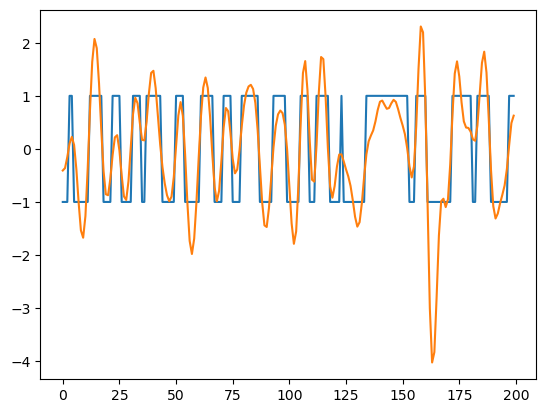

In [23]:
print(binarized_data.shape)
plt.plot(binarized_data[0, :, 0])
plt.plot(fmri_data[0, :, 0])

In [24]:
n_rois = 333 #333

all_data = binarized_data[:,:,:].reshape(len(subjects)*200,n_rois).T

# Create the variables needed to create the inet object
# Create empty ising parameters
h_archetype = np.zeros(n_rois)
j_archetype = np.zeros([n_rois, n_rois])
# Create empty iNeT
archetype_inet = Inet(h_archetype, j_archetype)

# Create the archetype dictionary (input for iTailor). In this case, as we
# create an archetype and we are not estimating personalized models, we do not
# give an archetype to it, so we pass None. We pass the empty inet object to
# the itailor class and the data to update that empty inet to an archetype.
archetype_dictionary = dict()
archetype_dictionary["inet"] = archetype_inet
archetype_dictionary["archetype_h"] = None
archetype_dictionary["archetype_j"] = None
archetype_tailor = Itailor(archetype_dictionary, all_data)

# Set the method parameters for estimating the archetype
params_method = dict()
params_method["delta_t"] = 0.05
params_method["iteration_max"] = 1001
params_method["permissible_error"] = 1e-7
params_method["estimate_h"] = False

# Run the ezaki method to estimate h and J and update those attributes h and J
# to the object
archetype_tailor.run("archetype", params_method)

Itailor params: {'delta_t': 0.05, 'iteration_max': 1001, 'permissible_error': 1e-07, 'estimate_h': False, 'sparsity': 0}
number of steps: 0 norm: 0.00030908557200600676
number of steps: 500 norm: 6.192946220708356e-06
number of steps: 1000 norm: 8.460840181785183e-06


Text(0.5, 0, 'ROI')

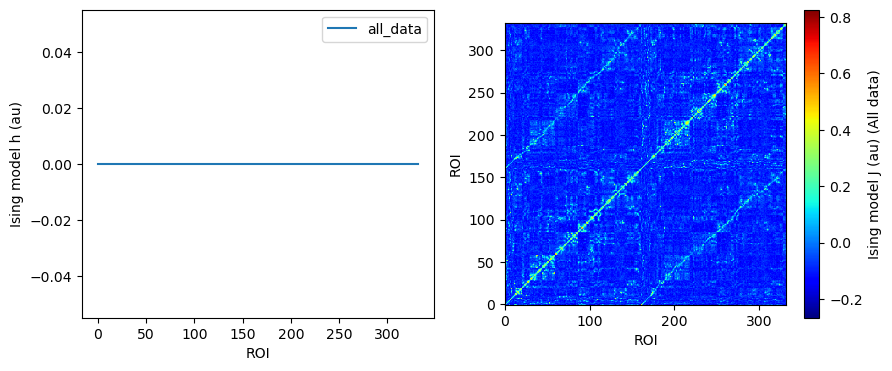

In [84]:
# Show both h and J results
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.xlabel("ROI")
plt.ylabel("Ising model h (au)")
plt.plot(archetype_inet.h_ising, label='all_data')
plt.legend()
#plt.ylim(-0.02,0.02)
plt.subplot(1,2,2)
plt.imshow(archetype_inet.j_ising , origin='lower', cmap='jet')
clb = plt.colorbar(label='Ising model J (au) (All data)')
plt.ylabel("ROI")
plt.xlabel("ROI")


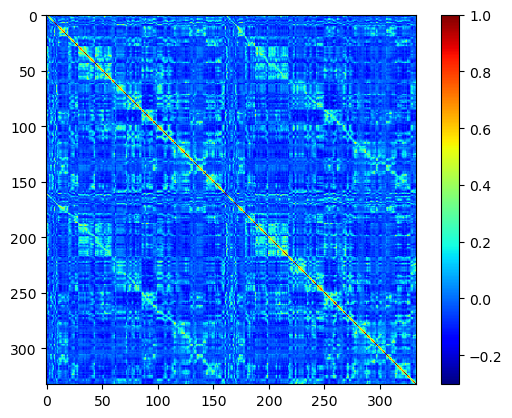

In [58]:
plt.imshow(np.corrcoef(all_data),  cmap='jet')
plt.colorbar()

In [54]:
j = archetype_inet.j_ising.copy()
np.fill_diagonal(j,0)

In [55]:
def personalize_T(archetype_inet, subject_data):
    """Personalize T for each subect from archetype (actually beta =1/t) and
    fullpack dictionary dataset ()'binTS' data)"""
    #
    n_parcels = np.array(subject_data).shape[0] # assume data shape is n_parcels x n_timepoints
    Ts = list()
    
    #Create the empty personalized iNet
    subj_h = np.zeros(n_parcels)
    subj_j = np.zeros([n_parcels,n_parcels])
    subj_inet = Inet(subj_h, subj_j)
    
    #Create the attributes for the itailor class, in this case we give the archetype we created before 
    #and the personal data
    inet_dictionary = dict()
    inet_dictionary["inet"] = subj_inet
    inet_dictionary["archetype_h"] = np.matrix(archetype_inet.h_ising, dtype=float) #Use the archetype we derived before
    inet_dictionary["archetype_j"] = np.matrix(j, dtype=float) 

    # Itailor object inputs archetype dictionary with J,h + the data for the subject:
    subj_tailor = Itailor(inet_dictionary, subject_data)

    # Set the parameters for the personalizion method
    betas = np.arange(0.4, 1.8,0.001)
    subj_tailor.run("personalized_H",{}, betas) #Get personalized h and J for subj_01
     
    print("subject T:", 1./subj_inet.beta,
          "fit error:",subj_tailor.method_output["minimum error"] )

        
    return 1./subj_inet.beta

In [60]:
temperatures_inets_lsd_both_sess  = [personalize_T(archetype_inet, binarized_data[subj].T) 
                                     for subj in range(len(subjects))]



Itailor params: {'permissible_error': 1e-09, 'delta_t': 0.05, 'iteration_max': 2000, 'sparsity': 0, 'estimate_h': True}
subject T: 1.5797788309636644 fit error: 1.8192393468930412e-07
Itailor params: {'permissible_error': 1e-09, 'delta_t': 0.05, 'iteration_max': 2000, 'sparsity': 0, 'estimate_h': True}
subject T: 1.5898251192368833 fit error: 3.3637951772475217e-09
Itailor params: {'permissible_error': 1e-09, 'delta_t': 0.05, 'iteration_max': 2000, 'sparsity': 0, 'estimate_h': True}
subject T: 1.6583747927031502 fit error: 2.2911527496116556e-08
Itailor params: {'permissible_error': 1e-09, 'delta_t': 0.05, 'iteration_max': 2000, 'sparsity': 0, 'estimate_h': True}
subject T: 1.4970059880239515 fit error: 1.681619369291589e-08
Itailor params: {'permissible_error': 1e-09, 'delta_t': 0.05, 'iteration_max': 2000, 'sparsity': 0, 'estimate_h': True}
subject T: 1.468428781204111 fit error: 1.2381754796003874e-07
Itailor params: {'permissible_error': 1e-09, 'delta_t': 0.05, 'iteration_max': 200

In [69]:
from scipy import stats

print(stats.pearsonr(temperatures_inets_lsd_both_sess[:50], y.y_pred.values))


PearsonRResult(statistic=-0.6250817079983199, pvalue=1.2188445852197796e-06)


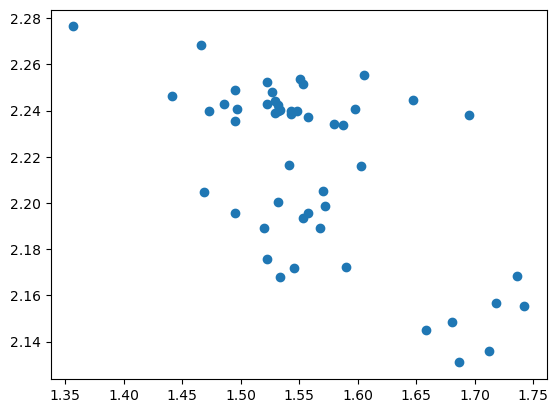

In [71]:
plt.scatter(temperatures_inets_lsd_both_sess[:50], y.y_pred.values)

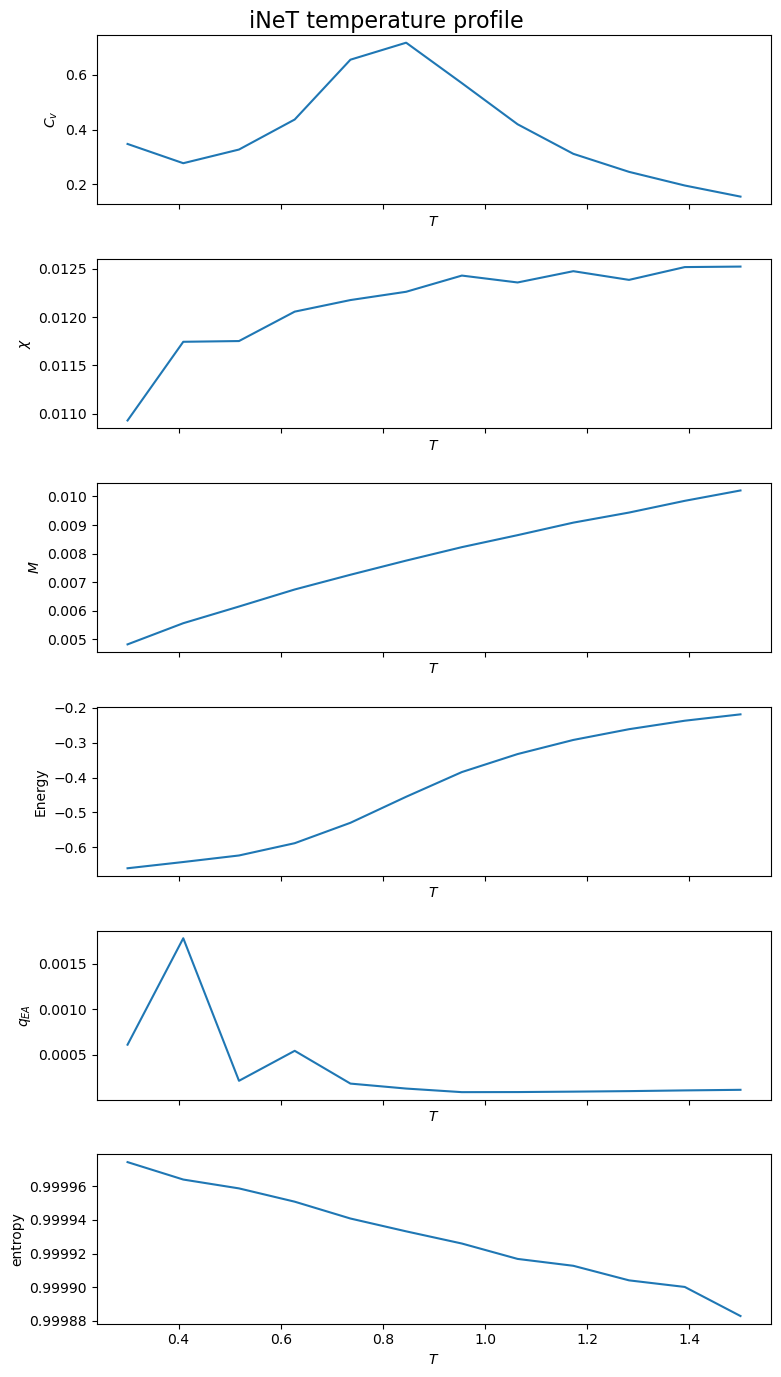

Tc: 1.5
Max chi: 0.01
total time was 0.96 hours
total time was 3443.1 seconds


In [86]:
import time as time
t = time.time()

temperatures = np.linspace(0.3, 1.5, 12) 
iterations = 5000000 # > 10e6

archetype_inet.h_ising = np.ravel(archetype_inet.h_ising)
archetype_inet.j_ising = archetype_inet.j_ising 

[heats, susceptibilities,
                energies,
                magnetizations, q_EAs, entropies] = archetype_inet.simulate_and_plot(
    temperatures, iterations)

elapsed = time.time() - t
print('total time was', np.round(elapsed/3600, 2), 'hours')
print('total time was', np.round(elapsed, 2), 'seconds')
